In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

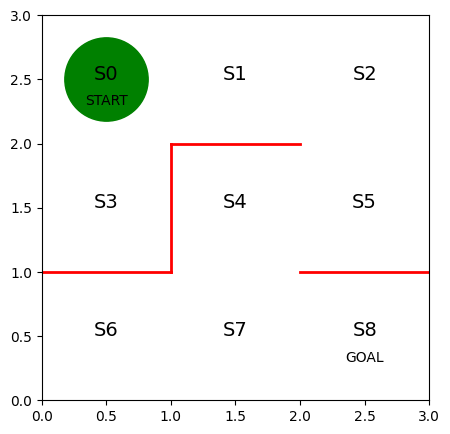

In [2]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', size=10, ha='center')
plt.text(2.5, 0.3, 'GOAL', size=10, ha='center')

line, = ax.plot([0.5], [2.5], marker='o', color='green', markersize=60)

## 1. 基本概念和术语
- algorithm
    - policy iteration
        - policy gradient
    - value iteration
        - sarsa: state, action, reward, state, action
            - Q-table 待学习（learning/iteration update）
                - row index: state;column index;action;
                - 不是概率分布，是value
- reward
    - 特定时间 $t$ 给到的奖励 $R_t$ 称为及时奖励
    - 未来总奖励
        - $G_t=R_{t+1}+R_{t+2}+...$
        - $G_T=R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+...$     
        - $\gamma$ 折扣系数，更少步数完成
    - 距离Q-table
        - $Q_\pi(s=7,a=1) = R_{t+1} =1 $
        - $Q_\pi(s=7,a=0) = \gamma^2$
- action value, state value
- bellman equation
    - 适用于状态价值函数（state value function），也适用于动作价值函数（action value function）
- mdp: markov decision process
    - 马尔科夫性 $s_{t+1}$ 只和 $s_{t}$ 时刻相关
        - $ p(s_{t+1}|s_t) = p(s_{t+1}|s_1,s_2,s_3,...,s_t)$  

## 2. Sarsa(state, action, reward, state, action) impl

In [7]:
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],  # s0
                      [np.nan, 1, np.nan, 1],  # s1
                      [np.nan, np.nan, 1, 1],  # s2
                      [1, np.nan, np.nan, np.nan],  # s3
                      [np.nan, 1, 1, np.nan],  # s4
                      [1, np.nan, np.nan, 1],  # s5
                      [np.nan, 1, np.nan, np.nan],  # s6
                      [1, 1, np.nan, 1],  # s7
                      #  [np.nan, np.nan, np.nan, 1],  # s8
                      ])
n_states, n_actions = theta_0.shape
Q = np.random.rand(n_states, n_actions)*theta_0
Q

array([[       nan, 0.52072876, 0.87299134,        nan],
       [       nan, 0.26309854,        nan, 0.78300149],
       [       nan,        nan, 0.06445602, 0.17890206],
       [0.82773632,        nan,        nan,        nan],
       [       nan, 0.73667813, 0.93981534,        nan],
       [0.76125649,        nan,        nan, 0.04606241],
       [       nan, 0.02406456,        nan,        nan],
       [0.20611357, 0.26054631,        nan, 0.22314104]])

### 2.1 $\epsilon$ - greedy(explore, exploit)

In [30]:
def cvt_theta_0_to_pi(theta):
    pi = np.zeros_like(theta)

    for r in range(theta.shape[0]):
        pi[r, :] = theta[r, :]/np.nansum(theta[r, :])
    return np.nan_to_num(pi)


cvt_theta_0_to_pi(theta_0)


def get_action(s, Q, epsilon, pi):
    action_space = list(range(4))
    if np.random.rand() < epsilon:
        action = np.random.choice(action_space, p=pi[s, :])  # random explore
    else:
        action = np.nanargmax(Q[s, :])  # exploit
    return action

### 2.2 Sarsa(update($Q_\pi(s,a)$))
- 理想情况 $ Q(s_t,a_t) = R_{t+1}+\gamma Q(s_{t+1},a_{t+1}) $
- $td=R_{t+1}+\gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)$
- final update equation: $Q(s_t,a_t)=Q(s_t,a_t)+\eta \cdot (R_{t+1}+\gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)) = Q(s_t,a_t)+\eta \cdot td$
- $\gamma$ 折扣系数

In [12]:
def sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a]+eta*(r-Q[s, a])
    else:
        Q[s, a] = Q[s, a]+eta*(r+gamma*Q[s_next, a_next]-Q[s, a])

In [15]:
from typing import Tuple


class MazeEnv(gym.Env):
    def __init__(self) -> None:
        self.state = 0
        self.goal = 8

    def step(self, action: int) -> Tuple[int, float, bool, bool, dict]:
        reward = 0.0
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        else:
            self.state -= 1
        if self.state == self.goal:
            reward = 1.0
        return self.state, reward, self.state == self.goal, True, {}

    def reset(self, *, seed: int | None = None, options: dict | None = None) -> Tuple[int, dict]:
        self.state = 0
        return self.state

In [27]:


class Agent:
    def _cvt_theta_0_to_pi(self, theta):
        pi = np.zeros_like(theta)

        for r in range(theta.shape[0]):
            pi[r, :] = theta[r, :]/np.nansum(theta[r, :])
        return np.nan_to_num(pi)

    def _softmax_cvt_theta_to_pi(self, theta, beta=1.0):
        pi = np.zeros_like(theta)
        exp_theta = np.exp(beta*theta)
        for r in range(theta.shape[0]):
            pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
        pi = np.nan_to_num(pi)
        return pi

    def __init__(self) -> None:
        self.eta = 0.1
        self.gamma = 0.9
        self.epsilon = 0.5
        self.actions = [0, 1, 2, 3]
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],  # s0
                                   [np.nan, 1, np.nan, 1],  # s1
                                   [np.nan, np.nan, 1, 1],  # s2
                                   [1, np.nan, np.nan, np.nan],  # s3
                                   [np.nan, 1, 1, np.nan],  # s4
                                   [1, np.nan, np.nan, 1],  # s5
                                   [np.nan, 1, np.nan, np.nan],  # s6
                                   [1, 1, np.nan, 1],  # s7
                                   #  [np.nan, np.nan, np.nan, 1],  # s8
                                   ])

        self.pi = self._cvt_theta_0_to_pi(self.theta_0)
        # self.theta = self.theta_0
        # print(*self.theta_0.shape)
        # print(self.theta_0.shape)
        # self.Q = np.random.rand(*self.theta_0.shape) * self.theta_0
        self.Q = np.random.rand(*self.theta_0.shape) * self.theta_0

    def choose_action(self, state: int):
        return get_action(state, self.Q, self.epsilon, self.pi)

    def sarsa(self, s, a, r, s_next, a_next):
        return sarsa(s, a, r, s_next, a_next, self.Q, self.eta, self.gamma)

## 3. 训练&更新

In [34]:
env = MazeEnv()
agent = Agent()
epoch = 1
agent.Q

while True:
    old_Q = np.nanmax(agent.Q, axis=1)
    state = env.reset()
    action = agent.choose_action(state)
    done = False
    s_a_history = [[state, np.nan]]
    while not done:
        s_a_history[-1][1] = action
        s_next, reward, done, _, _ = env.step(action)
        s_a_history.append([state, np.nan])
        if done:
            a_next = np.nan
        else:
            a_next = agent.choose_action(s_next)
        agent.sarsa(state, action, reward, s_next, a_next)
        state, action = s_next, a_next
    update = np.sum(np.abs(np.nanmax(agent.Q, axis=1) - old_Q))
    epoch += 1
    agent.epsilon /= 2
    print(f"epoch:{epoch} update:{update} len:{len(s_a_history)}")
    if epoch > 100 or update < 1e-5:
        break

epoch:2 update:0.6793435724579122 len:39
epoch:3 update:0.24284747565893444 len:21
epoch:4 update:0.1650578577339748 len:7
epoch:5 update:0.16410959377451484 len:11
epoch:6 update:0.13358654957828675 len:7
epoch:7 update:0.11766574932616725 len:7
epoch:8 update:0.33019861711538895 len:123
epoch:9 update:0.07424090904013575 len:13
epoch:10 update:0.0700367622197357 len:13
epoch:11 update:0.055375729245666694 len:7
epoch:12 update:0.05971824091556216 len:9
epoch:13 update:0.05323457598605558 len:7
epoch:14 update:0.056844984021211076 len:9
epoch:15 update:0.0519350217010921 len:7
epoch:16 update:0.050406351134676064 len:7
epoch:17 update:0.04915414883782815 len:7
epoch:18 update:0.04848182490726616 len:7
epoch:19 update:0.04773394707625234 len:7
epoch:20 update:0.046912601861188896 len:7
epoch:21 update:0.04602095208217477 len:7
epoch:22 update:0.04506303042715526 len:7
epoch:23 update:0.04404355821783573 len:7
epoch:24 update:0.043382609719161025 len:7
epoch:25 update:0.0429301165443197

In [35]:
agent.Q

array([[       nan, 0.57254026, 0.02693468,        nan],
       [       nan, 0.64802052,        nan, 0.29353272],
       [       nan,        nan, 0.72608258, 0.30835146],
       [0.21063645,        nan,        nan,        nan],
       [       nan, 0.2784117 , 0.89985635,        nan],
       [0.14177601,        nan,        nan, 0.80920807],
       [       nan, 0.38514776,        nan,        nan],
       [0.48903298, 0.99998694,        nan, 0.52548494]])

## 3. render&animation

In [36]:
from IPython.display import HTML
from matplotlib import animation


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    state = s_a_history[i][0]
    x, y = (state % 3)+0.5, 2.5-int(state/3)
    line.set_data(x, y)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200)
anim.save("find_goal.gif")
HTML(anim.to_jshtml())

/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_22835/4122485094.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_22835/4122485094.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
